{% include toc title="This Week" icon="file-text" %}

<div class="notice--info" markdown="1">

## <i class="fa fa-ship" aria-hidden="true"></i> Welcome to Week {{ page.week }}!

Welcome to week {{ page.week }} of Earth Analytics! This week you will learn how to automate a workflow using `Python`. You will design and implement your own workflow in `Python` that builds on the skills that you have learned in this course, such as functions and loops. You will also learn how to programmatically build paths to directories and files as well as parse strings to extract information from file and directory names.  

{% include/data_subsets/course_earth_analytics/_data-landsat-automation.md %}


</div>


## Materials to Review For This Week's Assignment

Please be sure to review Chapter of Section 6 of the Intermediate Earth Analytics Textbook on <a href="{{ site.url }}/courses/use-data-open-source-python/earth-data-science-workflows/design-efficient-automated-data-workflows/">Designing and Automating Data Workflows in Python</a>. 



### Automate a Workflow in Python

For this week’s assignment, you will generate a plot of the normalized difference vegetation index (NDVI) for two different locations in the United States to begin to understand how the growing seasons vary in each site:

1. <a href="https://www.neonscience.org/field-sites/field-sites-map/SJER" target="_blank">San Joaquin Experimental Range (SJER) in Southern California, United States</a>
2. <a href="https://www.neonscience.org/field-sites/field-sites-map/HARV" target="_blank">Harvard Forest (HARV) in the Eastern United States</a> 

From this plot, you will be able to compare the seasonal vegetation patterns of the two locations. This comparison would be useful if you were planning NEON’s upcoming flight season in both locations and wanted to ensure that you flew the area when the vegetation was the most green! If could also be useful if you wanted to track green-up as it happened over time in both sites to see if there were changes happening. 

As a bonus, you will also create a stacked NDVI output data product to share with your colleagues. You are doing all of the work to clean and process the data. It would be nice if you could share a data product output to save others the hassle. 


### Design A Workflow 

Your goal this week is to calculate the mean NDVI value for each Landsat 8 scene captured for a NEON site over a year. You have the following data to do accomplish this goal:

1. One year worth of Landsat 8 data for each site: Remember that for each landsat scene, you have a series of geotiff files representing bands and qa (quality assurance) layers in your data.
2. A site boundary “clip file” for each site: This is a shapefile representing the boundary of each NEON site. You will want to clip your landsat data to this boundary.

Before writing `Python` code, write pseudocode for your implementation. Pseudo-coding means that you will write out all of the steps that you need to perform. Then, you will identify areas where tasks are repeated that could benefit from a function, areas where loops might be appropriate, etc.  


## Homework Plots

The plots below are examples of what your output plots will look like with and without cleaning the data to deal with cloud cover.


In [1]:
import os
from glob import glob
import numpy as np
import numpy.ma as ma
import pandas as pd
import functools
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import rasterio as rio
import geopandas as gpd

#import rasterstats as rs
import earthpy as et
import earthpy.spatial as es
import earthpy.mask as em
import warnings

warnings.filterwarnings("ignore")
# Get data
data = et.data.get_data("ndvi-automation")
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [2]:
# Get a list of each directory
path = os.path.join("data", "ndvi-automation", "sites")

# Get a list of each directory
sites = glob(path + "/*/")

# Define columns and list used to create pandas dataframe
col_names = ["site", "date", "ndvi"]
output = []

for site in sites:

    # Get site name
    site_name = os.path.basename(os.path.normpath(site))

    # Define directories
    landsat_dir = os.path.join(site, "landsat-crop")
    vector_dir = os.path.join(site, "vector")

    # Define site boundary
    site_boundary_path = os.path.join(
        vector_dir,  site_name + "-crop.shp")
    site_bound = gpd.read_file(site_boundary_path)

    # Get list of landsat scene directories
    cropped_directories = glob(os.path.join(landsat_dir, "LC08*"))
    cropped_directories.sort()

    # Calculate NDVI for each directory
    for directory in cropped_directories:

        # Get date from directory name
        dir_head, dir_tail = os.path.split(directory)
        date = dir_tail[10:18]

       # Open bands
        raster_list = glob(os.path.join(directory, "*band*.tif"))
        raster_list.sort()

        with rio.open(raster_list[3]) as band_4:
            band_4_crop, band_4_meta = es.crop_image(
                band_4, site_bound)
            mask = (band_4_crop < 0) | (band_4_crop > 10000)
            band_4_crop_data = np.ma.masked_array(band_4_crop, mask)

        with rio.open(raster_list[4]) as band_5:
            band_5_crop, band_5_meta = es.crop_image(
                band_5, site_bound)
            mask = (band_5_crop < 0) | (band_5_crop > 10000)
            band_5_crop_data = np.ma.masked_array(band_5_crop, mask)

        # Calculate NDVI for site using masked data
        ndvi_landsat = es.normalized_diff(
            band_5_crop_data.astype('f4'), band_4_crop_data.astype('f4'))

        # Add date and NDVI mean to list
        output.append([site_name, date, np.nanmean(ndvi_landsat)])

# Convert list to pandas dataframe and save to csv
ndvi_ts = pd.DataFrame(output, columns=col_names)
out_path_no_clean = os.path.join(
    "data", "ndvi-automation", "outputs", "ndvi_2017_not_clean.csv")
ndvi_ts.to_csv(out_path_no_clean)

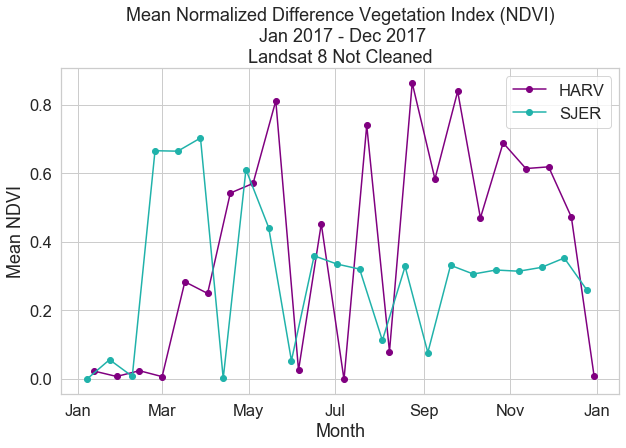

In [3]:
# Read ndvi csv
ndvi_df = pd.read_csv(out_path_no_clean,
                      parse_dates=['date'],
                      index_col=['date'])

colors = {'SJER': 'lightseagreen', 'HARV': 'purple'}

grouped = ndvi_df.dropna().groupby('site')

fig, ax = plt.subplots(figsize=(10, 6))

for key, group in grouped:
    ax.plot(group.index.values,
            group['ndvi'].values,
            label=key,
            color=colors[key],
            marker='o')

ax.legend(bbox_to_anchor=(1, 1))

# Format tick labels
locator = mdates.MonthLocator(interval=2)
ax.xaxis.set_major_locator(locator)
myFmt = DateFormatter("%b")
ax.xaxis.set_major_formatter(myFmt)

# Set title and labels for axes
ax.set(xlabel="Month",
       ylabel="Mean NDVI",
       title="Mean Normalized Difference Vegetation Index (NDVI)\n Jan 2017 - Dec 2017\nLandsat 8 Not Cleaned")

plt.show()

In [4]:
# need to make a decision about how this is best edesing

# Should we fill the arr with no data values or create a masekd array?
# If the arr is already masked, then we'd want to append to that mask?


def open_clean_bands(band_path,
                     crop_bound,
                     nodata=None,
                     a_mask=None,
                     vals=None):
    """Take an input single band mask layer such as a pixel_qa 
    layer for MODIS or Landsat and apply a mask given a range of vals to mask

    Parameters
    -----------
    band_path : string
        A path to the array to be opened
    crop_bound : geopandas GeoDataFrame
        A geopandas dataframe to be used to crop the raster data using rasterio mask().
    nodata : tuple (optional)
        A tuple of min and max values to crop from the data. Default = None
    a_mask : numpy array
        A numpy array with values that have not yet been set to 1
    vals : list
        A list of values needed to create the cloud mask

    Returns
    -----------
    arr : numpy array
        A numpy array with values that should be masked set to 1 for True (Boolean)
    """
    # TODO add tests to ensure the arrays are the same .shape
    with rio.open(band_path) as band:
        band_crop, _ = es.crop_image(band, crop_bound)
        # if the Arr only has one dimension
    if len(band_4.shape) == 3 & band_4.shape[0] == 1:
        band_crop = np.squeeze(band_crop)
    if nodata:
        mask = (band_crop < nodata[0]) | (band_crop > nodata[1])
        band_crop = np.ma.masked_array(band_crop, mask)
    try:
        band_crop = em.mask_pixels(band_crop, cl_mask, vals)
    except:
        band_crop = np.ma.masked_array(band_crop)
    
    return band_crop

In [5]:
# Cloud no data vals for Landsat 8
vals = [328, 392, 840, 904, 1350, 352, 368, 416,
        432, 480, 864, 880, 928, 944, 992, 480, 992]


# Get a list of each directory
path = os.path.join("data", "ndvi-automation", "sites")

# Get a list of each directory
sites = glob(path + "/*/")

# Define columns and list used to create pandas dataframe
col_names = ["site", "date", "ndvi"]
output = []

for site in sites:

    # Get site name
    site_name = os.path.basename(os.path.normpath(site))

    # Define directories
    landsat_dir = os.path.join(site, "landsat-crop")
    vector_dir = os.path.join(site, "vector")

    # Open crop boundary
    site_boundary_path = os.path.join(vector_dir,  site_name + "-crop.shp")
    crop_bound = gpd.read_file(site_boundary_path)

    # Get list of landsat scene directories
    landsat_dirs = glob(os.path.join(landsat_dir, "LC08*"))
    landsat_dirs.sort()

    # Calculate NDVI for each directory
    for adir in landsat_dirs:

        # Get date from directory name
        dir_head, dir_tail = os.path.split(adir)
        date = dir_tail[10:18]

       # Open bands
        band_paths = glob(os.path.join(adir, "*band*[4-5].tif"))
        band_paths.sort()

       # Get cloud mask layer
        qa_r = glob(os.path.join(adir, "*qa*"))

        # Open the pixel_qa layer for landsat scene
        with rio.open(qa_r[0]) as landsat:
            cl_mask, _ = es.crop_image(landsat,
                                       crop_bound)

        all_bands = list(map(functools.partial(open_clean_bands,
                                               crop_bound=crop_bound,
                                               a_mask=cl_mask,
                                               vals=vals,
                                               nodata=(-10000, 10000)),
                             band_paths))

        # Calculate NDVI, if all pixels masked return -9999
        if all_bands[0].mask.all():
            ndvi = -9999
        else:
            ndvi = es.normalized_diff(all_bands[1], all_bands[0])

        # Add date and NDVI mean to list
        output.append([site_name, date, np.nanmean(ndvi)])

# Convert list to pandas dataframe and save to csv
ndvi_ts = pd.DataFrame(output, columns=col_names)
out_path = os.path.join("data", "ndvi-automation", "outputs", "ndvi_2017.csv")
ndvi_ts.to_csv(out_path)

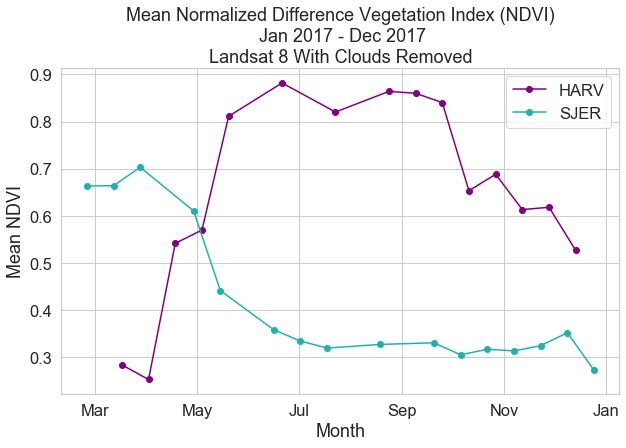

In [6]:
# Read ndvi csv
ndvi_df = pd.read_csv(out_path,
                      parse_dates=['date'],
                      na_values=[-9999],
                      index_col=['date'])

grouped = ndvi_df.dropna().groupby('site')

fig, ax = plt.subplots(figsize=(10, 6))

for key, group in grouped:
    ax.plot(group.index.values,
            group['ndvi'].values,
            label=key,
            color=colors[key],
            marker='o')

ax.legend(bbox_to_anchor=(1, 1))

# Format tick labels
locator = mdates.MonthLocator(interval=2)
ax.xaxis.set_major_locator(locator)
myFmt = DateFormatter("%b")
ax.xaxis.set_major_formatter(myFmt)

# Set title and labels for axes
ax.set(xlabel="Month",
       ylabel="Mean NDVI",
       title="Mean Normalized Difference Vegetation Index (NDVI)\n Jan 2017 - Dec 2017\nLandsat 8 With Clouds Removed")

plt.show()